Auteur : Francis de Ladurantaye<br>
Matricule : 990316<br>
Date : 2018/11/22

In [1]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

train_data = np.loadtxt('EMGaussian.train')
test_data = np.loadtxt('EMGaussian.test')

In [2]:
# number of classes and dimension of data
K = 4
d = train_data.shape[1]

### Initial values of parameters

In [3]:
π_0 = np.ones(K) / K

In [4]:
A_0 = np.ones((K,K)) / (2 * (K - 1))

for i in range(K):
    A_0[i,i] = 1/2

In [5]:
μ_0 = np.asarray([[-2.0344,  4.1726],
                  [ 3.9779,  3.7735],
                  [ 3.8007, -3.7972],
                  [-3.0620, -3.5345]])

In [6]:
Σ_0 = np.ndarray((K,d,d))

Σ_0[0] = np.asarray([[2.9044, 0.2066],
                     [0.2066, 2.7562]])

Σ_0[1] = np.asarray([[0.2104, 0.2904],
                     [0.2904, 12.2392]])

Σ_0[2] = np.asarray([[0.9213, 0.0574],
                     [0.0574, 1.8660]])

Σ_0[3] = np.asarray([[6.2414, 6.0502],
                     [6.0502, 6.1825]])

### 2.1) α and β recursions

In [7]:
def N_x(x, μ, Σ, Σ_inverse = None):
    
    p_x = np.ndarray(K)
    
    diff = x - μ
    
    if len(Σ.shape) == 3:  # general covariance matrix
        
        if Σ_inverse is None:
            Σ_inverse = np.linalg.pinv(Σ)
        
        for k in range(K):
            p_x[k] = np.exp(-1/2 * np.matmul(diff[k].T, Σ_inverse[k].dot(diff[k])))
            p_x[k] /= (2 * np.pi)**(d/2) * np.linalg.det(Σ[k])**(1/2)
            
    elif len(Σ.shape) == 1:  # proportional to identity covariance matrix
        
        for k in range(K):
            p_x[k] = np.exp(-1/2 * np.dot(diff[k], diff[k]) / Σ[k])
            p_x[k] /= (2 * np.pi * Σ[k])**(d/2)
            
    else:
        raise Exception('Covariance must be of dim 3 (general covariance) or dim 1 (proportional to identity)!')
        
    return p_x

In [8]:
def α_recursion(data, π, μ, Σ, A):
    
    T = data.shape[0]
    α = np.ndarray((T,K))
    c = np.ndarray(T)
    
    Σ_inverse = np.linalg.inv(Σ)
    
    p_x = N_x(data[0], μ, Σ, Σ_inverse)
    α[0] = p_x * π
    c[0] = p_x @ α[0]
    α[0] /= c[0]
    
    for t in range(1, T):
        p_x = N_x(data[t], μ, Σ, Σ_inverse)
        α[t] = p_x * np.matmul(A, α[t-1])
        c[t] = p_x @ α[t]
        α[t] /= c[t]
    
    return α, c

In [9]:
def β_recursion(data, π, μ, Σ, A, c):
    
    T = data.shape[0]
    β = np.ones((T,K))
    
    Σ_inverse = np.linalg.inv(Σ)
    
    β[-1] = np.ones(K)
    
    for t in range(T-2, -1, -1):
        p_x_tp1 = N_x(data[t+1], μ, Σ, Σ_inverse)
        β[t] = A.T @ (p_x_tp1 * β[t+1])
        β[t] /= c[t+1]
    
    return β

### 2.2)  Marginal probabilities $p(z_t|x_{1:T})$ of test data using parameters learnt with GMM

In [10]:
def plot_posteriors(data, π, μ, Σ, A, time_steps = 100):

    α, c = α_recursion(data, π, μ, Σ, A)
    β = β_recursion(data, π, μ, Σ, A, c)

    p_z_x = α[:time_steps] * β[:time_steps]
    p_x = np.sum(p_z_x, axis=1).reshape((time_steps,1))
    γ = np.divide(p_z_x, p_x)

    x = np.arange(time_steps)

    for k in range(K):
        plt.subplot(K, 1, k+1)
        plt.title('z = ' + str(k+1))
        plt.xlabel('t')
        plt.ylabel('p ( z | x )')
        plt.bar(x, γ[:,k])
        plt.show()
    
    return γ

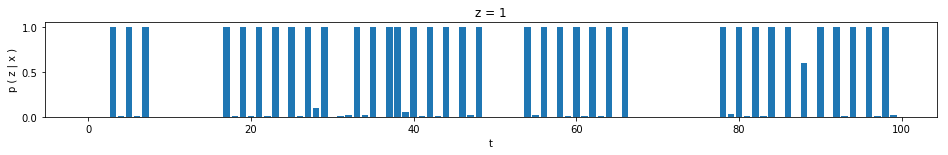

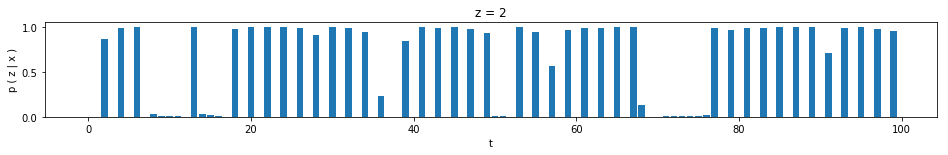

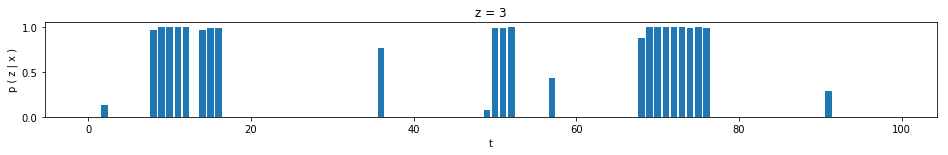

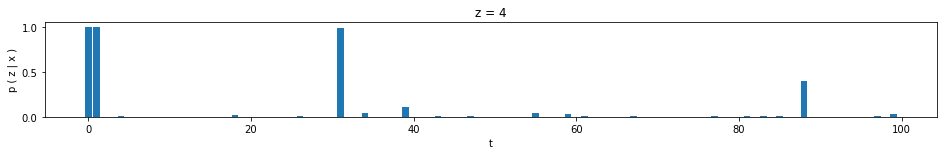

In [11]:
plt.rcParams["figure.figsize"] = [16,8]
_ = plot_posteriors(test_data, π_0, μ_0, Σ_0, A_0)

### 2.4) EM algorithm for HMM and parameter learning using train data

In [12]:
def HMM_train(data, π_0, μ_0, Σ_0, A_0, threshold = 1/10000):

    # initialization
    T = data.shape[0]
    ξ = np.ndarray((T-1, K, K))
    likelihoods = []

    π = np.copy(π_0)
    μ = np.copy(μ_0)
    Σ = np.copy(Σ_0)
    A = np.copy(A_0)
    
    while len(likelihoods) < 2 or np.abs(likelihoods[-1] - likelihoods[-2]) > threshold:
        
        ### E step ###

        # α and β recursions
        α, c = α_recursion(data, π, μ, Σ, A)
        β = β_recursion(data, π, μ, Σ, A, c)

        # γ computation (posterior probability)
        p_z_x = α * β
        p_x = np.sum(p_z_x, axis=1).reshape((T,1))
        γ = np.divide(p_z_x, p_x)
        
        # ξ computation (edge marginal)
        Σ_inverse = np.linalg.inv(Σ)
        for t in range(T-1):
            p_x_tp1 = N_x(data[t+1], μ, Σ, Σ_inverse).reshape((K,1))
            ξ[t] = np.outer(β[t+1], α[t]) * A * p_x_tp1 / c[t+1]
            
        # soft counts
        soft_counts = np.sum(γ, axis=0)
        
        
        ### M step ###

        # set posterior at t=0 as the new prior
        π = γ[0]

        # μ computation
        μ = np.zeros((K, d))
        for k in range(K):
            μ[k] = np.sum(γ[:,k].reshape((T,1)) * data, axis=0) / soft_counts[k]

        # Σ computation
        Σ = np.zeros((K, d, d))
        for k in range(K):
            diff = data - μ[k]
            for t in range(T):
                Σ[k] += γ[t,k] * np.outer(diff[t], diff[t])
            Σ[k] /= soft_counts[k]

        # A computation
        ξ_sum = np.sum(ξ, axis=0)
        A = np.divide(ξ_sum, np.sum(ξ_sum, axis=0))
        
        # complete log-likelihood computation
        likelihoods.append(np.sum(np.log(c)) / T)
        
    return π, μ, Σ, A, np.asarray(likelihoods)

In [13]:
data = train_data
# data = test_data

π, μ, Σ, A, log_likelihood = HMM_train(data, π_0, μ_0, Σ_0, A_0)
print('π = \n' + str(π))
print('μ = \n' + str(μ))
print('Σ = \n' + str(Σ))
print('A = \n' + str(A))

π = 
[1.62326086e-09 3.08536513e-49 4.57644928e-17 9.99999998e-01]
μ = 
[[-1.95058163  4.19380786]
 [ 3.99441558  3.63555913]
 [ 3.78931199 -3.9735154 ]
 [-2.96884022 -3.44595632]]
Σ = 
[[[ 3.28139553  0.30349664]
  [ 0.30349664  2.83084557]]

 [[ 0.19760906  0.25899728]
  [ 0.25899728 12.33571656]]

 [[ 0.94399     0.06158334]
  [ 0.06158334  1.55752183]]

 [[ 6.80928197  6.58546091]
  [ 6.58546091  6.68652047]]]
A = 
[[0.01576235 0.93268671 0.040004   0.00675316]
 [0.87474098 0.02272425 0.04713136 0.07242888]
 [0.04647207 0.01194481 0.87867077 0.02014113]
 [0.0630246  0.03264423 0.03419387 0.90067682]]


### 2.5) Log-likelihoods of train and test data

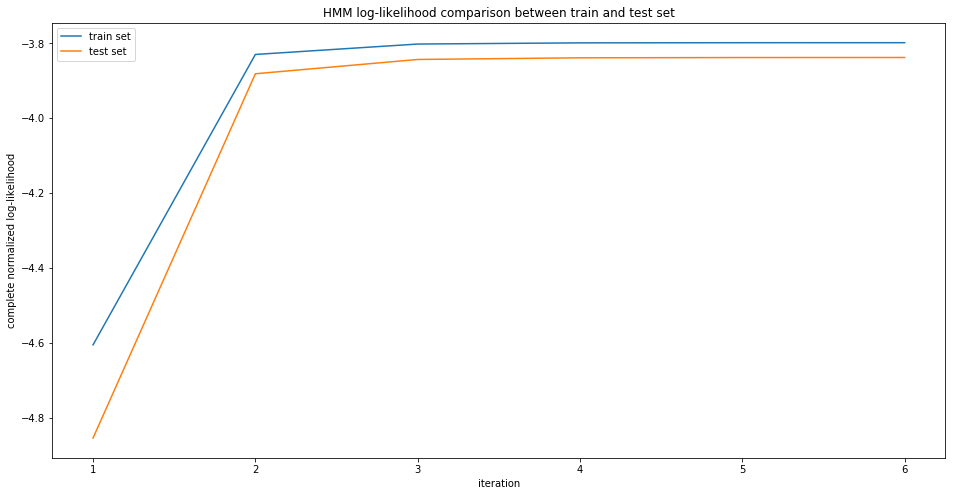

In [14]:
_, _, _, _, train_log_likelihoods = HMM_train(train_data, π_0, μ_0, Σ_0, A_0)
_, _, _, _, test_log_likelihoods = HMM_train(test_data, π_0, μ_0, Σ_0, A_0)

n_iterations = np.minimum(train_log_likelihoods.shape[0], test_log_likelihoods.shape[0])
x = np.arange(n_iterations) + 1

plt.plot(x, train_log_likelihoods[:n_iterations], label='train set')
plt.plot(x, test_log_likelihoods[:n_iterations], label='test set')
plt.title('HMM log-likelihood comparison between train and test set')
plt.xlabel('iteration')
plt.ylabel('complete normalized log-likelihood')
plt.legend()
plt.show()

### 2.6) Log-likelihoods comparison between HMM and GMM

In [15]:
def K_means_train(data):
    
    # number of elements in 'data'
    N = data.shape[0]
    
    # we randomly initialize our K means using K random data points
    indexes = np.arange(N)
    np.random.shuffle(indexes)
    μ_tp1 = np.copy(data[indexes[:K]])
    μ_t = np.zeros((K,d))
    
    while(np.any(μ_tp1 != μ_t)):
        
        μ_t = np.copy(μ_tp1)
        
        ### E step ###
        z = np.zeros((N,K))
        dist = np.ndarray((N,K))
        
        for k in range(K):
            diff = data - μ_t[k]
            dist[:,k] = np.sum(diff ** 2, axis=1)
            
        z[np.arange(N), np.argmin(dist, axis=1)] = 1
        
        #### M step ###
        class_counts = np.sum(z, axis=0)
        for k in range(K):
            μ_tp1[k] = np.dot(z[:,k], data) / class_counts[k]
    
    π = np.sum(z, axis=0) / np.sum(z)
    
    return π, μ_t

In [16]:
def GMM_log_likelihood(data, π, μ, Σ):
    
    N = data.shape[0]
    p_x_z = np.ndarray((N,K))
    
    if len(Σ.shape) == 3:  # general covariance matrix
    
        Σ_inverse = np.linalg.pinv(Σ)
        for i in range(N):
            p_x_z[i] = π * N_x(data[i], μ, Σ, Σ_inverse)
        
    elif len(Σ.shape) == 1:  # proportional to identity covariance matrix
    
        for i in range(N):
            p_x_z[i] = π * N_x(data[i], μ, Σ)
        
    else:
        raise Exception('Covariance must be of dim 3 (general covariance) or dim 1 (proportional to identity)!')
    

    p_x = np.sum(p_x_z, axis=1)
    log_p_x = np.log(p_x)
    
    log_likelihood = np.sum(log_p_x) / N
    
    return log_likelihood

In [17]:
def GMM_σ2I_train(data, π_0, μ_0, threshold = 1/10000):
    
    # initialization
    N = data.shape[0]
    p_x_z = np.ndarray((N, K))
    likelihoods = []
    
    π = np.copy(π_0)
    μ = np.copy(μ_0)
    σ2 = 10 * np.ones(K)
    
    while len(likelihoods) < 2 or np.abs(likelihoods[-1] - likelihoods[-2]) > threshold:

        ### E step ###
        
        # γ computation (posterior probability)
        for i in range(N):
            p_x_z[i] = π * N_x(data[i], μ, σ2)
        γ = np.divide(p_x_z, np.sum(p_x_z, axis=1).reshape((N,1)))
        
        # soft counts
        soft_counts = np.sum(γ, axis=0)
        
        
        ### M step ###
        
        # π computation
        π = soft_counts / N
        
        # μ computation
        μ = np.zeros((K, d))
        for k in range(K):
            μ[k] = np.sum(γ[:,k].reshape((N,1)) * data, axis=0) / soft_counts[k]
        
        # σ² computation
        σ2 = np.zeros(K)
        for k in range(K):
            diff = data - μ[k]
            for i in range(N):
                σ2[k] += γ[i,k] * np.dot(diff[i], diff[i])
            σ2[k] /= d * soft_counts[k]
        
        # complete log-likelihood
        likelihoods.append(GMM_log_likelihood(data, π, μ, σ2))
    
    return π, μ, σ2, np.asarray(likelihoods)

In [18]:
def GMM_Σ_train(data, π_0, μ_0, threshold = 1/10000):
    
    # initialization
    N = data.shape[0]
    p_x_z = np.ndarray((N, K))
    likelihoods = []
    
    π = np.copy(π_0)
    μ = np.copy(μ_0)
    Σ = np.ndarray((K, d, d))
    for k in range(K):
        Σ[k] = 10 * np.identity(d)
    
    while len(likelihoods) < 2 or np.abs(likelihoods[-1] - likelihoods[-2]) > threshold:
        
        ### E step ###
        
        # γ computation (posterior probability)
        Σ_inverse = np.linalg.pinv(Σ)
        for i in range(N):
            p_x_z[i] = π * N_x(data[i], μ, Σ, Σ_inverse)
        γ = np.divide(p_x_z, np.sum(p_x_z, axis=1).reshape((N,1)))
        
        # soft counts
        soft_counts = np.sum(γ, axis=0)
        
        
        ### M step ###
        
        # π computation
        π = soft_counts / N
        
        # μ computation
        μ = np.zeros((K, d))
        for k in range(K):
            μ[k] = np.sum(γ[:,k].reshape((N,1)) * data, axis=0) / soft_counts[k]
        
        # Σ computation
        Σ = np.zeros((K, d, d))
        for k in range(K):
            diff = data - μ[k]
            for i in range(N):
                Σ[k] += γ[i,k] * np.outer(diff[i], diff[i])
            Σ[k] /= soft_counts[k]
        
        # complete log-likelihood
        likelihoods.append(GMM_log_likelihood(data, π, μ, Σ))
    
    return π, μ, Σ, np.asarray(likelihoods)

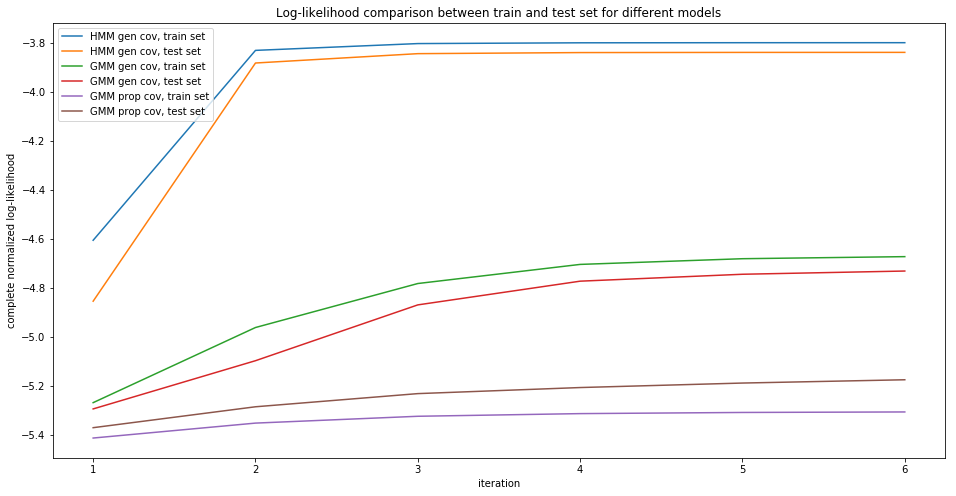

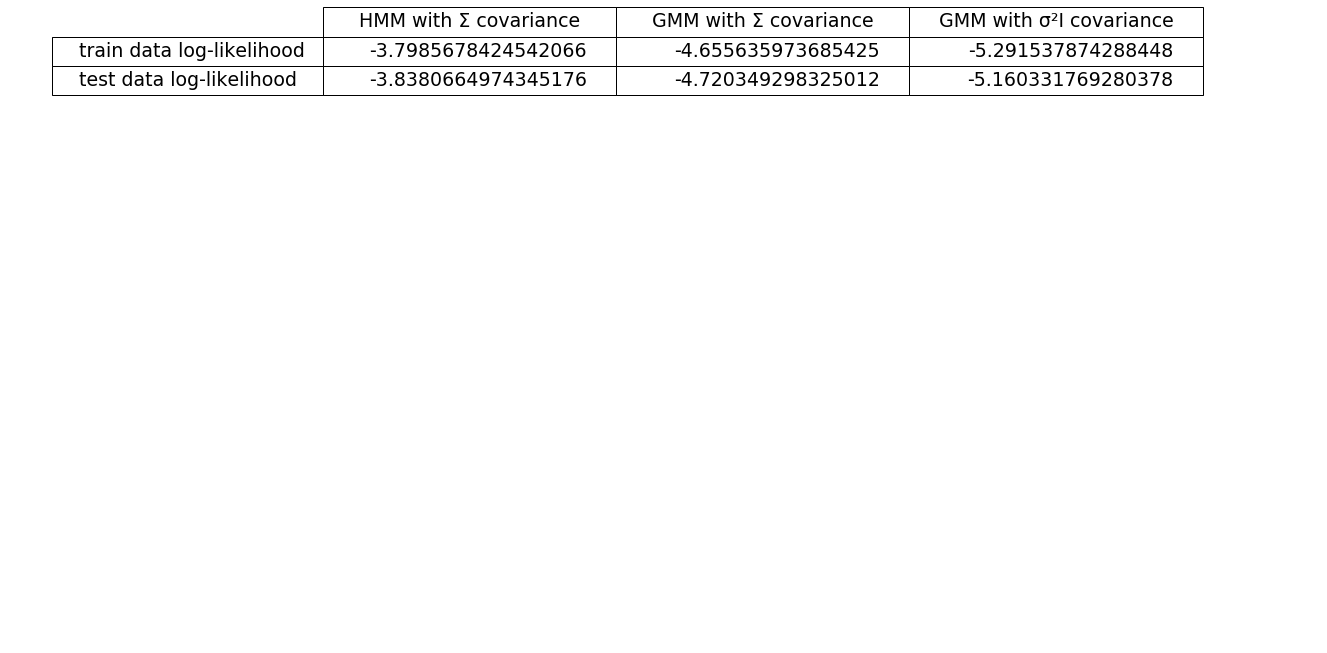

In [19]:
π_Kmeans, μ_Kmeans = K_means_train(train_data)

likelihoods = []


for data in [train_data, test_data]:
    
    # HMM with general covariance
    _, _, _, _, log_likelihood = HMM_train(data, π_0, μ_0, Σ_0, A_0)
    likelihoods.append(log_likelihood)
    
    # GMM with general covariance
    _, _, _, log_likelihood = GMM_Σ_train(data, π_Kmeans, μ_Kmeans)
    likelihoods.append(log_likelihood)
    
    # GMM with proportional to identity covariance
    _, _, _, log_likelihood = GMM_σ2I_train(data, π_Kmeans, μ_Kmeans)
    likelihoods.append(log_likelihood)

    
# retrieve the smallest number of iterations (for plotting)
n_iterations = np.inf
for likelihood in likelihoods:
    if len(likelihood) < n_iterations:
        n_iterations = len(likelihood)
        
x = np.arange(n_iterations)


# plot log-likelihoods by iteration count
for i in range(int(len(likelihoods) / 2)):
    
    if i % 3 == 0:
        label = 'HMM gen cov, '
    elif i % 3 == 1:
        label = 'GMM gen cov, '
    else:
        label = 'GMM prop cov, '
    
    plt.plot(x+1, likelihoods[i][:n_iterations], label=label+'train set')
    plt.plot(x+1, likelihoods[i+3][:n_iterations], label=label+'test set')

plt.title('Log-likelihood comparison between train and test set for different models')
plt.xlabel('iteration')
plt.ylabel('complete normalized log-likelihood')
plt.legend()
plt.show()


# display log-likelihoods in a table
columns = ('HMM with Σ covariance', 'GMM with Σ covariance', 'GMM with σ²I covariance')
rows = ('train data log-likelihood', 'test data log-likelihood')
cell_text = np.asarray([likelihood[-1] for likelihood in likelihoods]).reshape((2,3))

table = plt.table(cellText=cell_text,
                  rowLabels=rows,
                  colLabels=columns,
                  loc='top')

table.set_fontsize(22)
table.scale(0.8, 2)
plt.tight_layout()
plt.axis('off')
plt.show()

### 2.8) Viterbi algorithm and classification of train data

In [20]:
def viterbi(data, π, μ, Σ, A):
    
    T = data.shape[0]
    ω = np.ndarray((T, K))
    
    Σ_inverse = np.linalg.inv(Σ)
    
    ω[0] = np.log(π) + np.log(N_x(data[0], μ, Σ, Σ_inverse))
    
    for t in range(1, T):
        
        p_x = N_x(data[t], μ, Σ, Σ_inverse)
        ω[t] = np.log(p_x) + np.max(np.log(A) + ω[t-1], axis=1)
        
    return np.argmax(ω, axis=1)

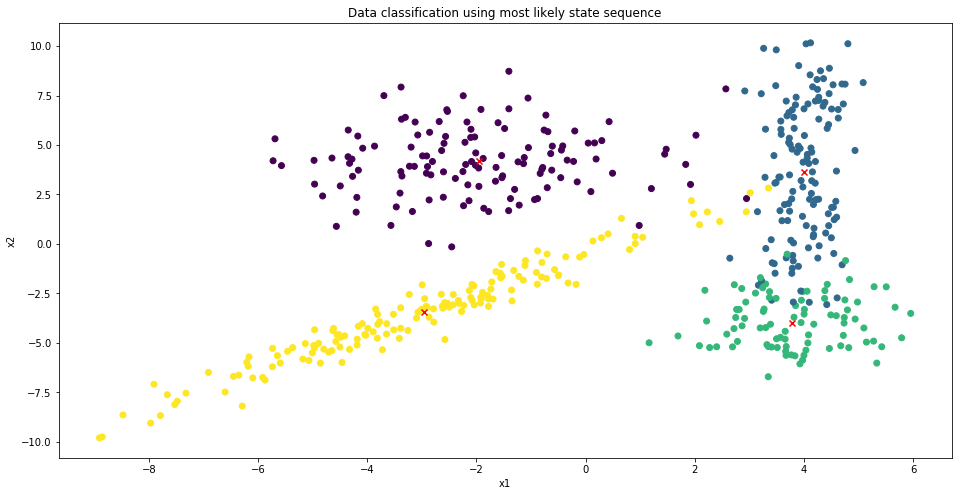

In [21]:
data = train_data
# data = test_data

ω = viterbi(data, π, μ, Σ, A)

plt.scatter(data[:,0], data[:,1], c=ω)
plt.scatter(μ[:,0], μ[:,1], c='r', marker='x')
plt.title('Data classification using most likely state sequence')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

### 2.9) Marginal probabilities $p(z_t|x_{1:T})$ of test data using parameters learnt with HMM

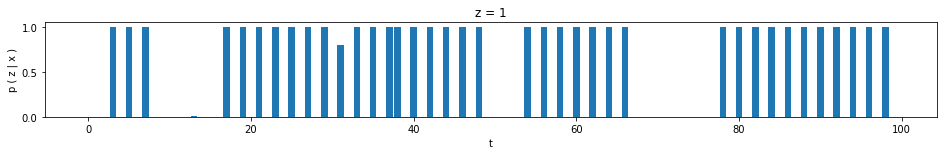

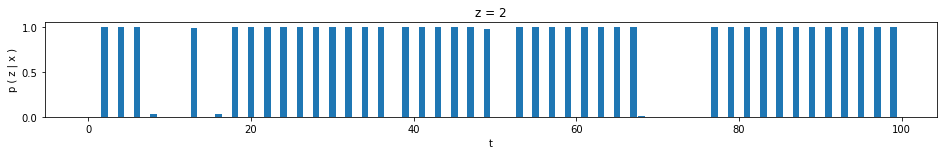

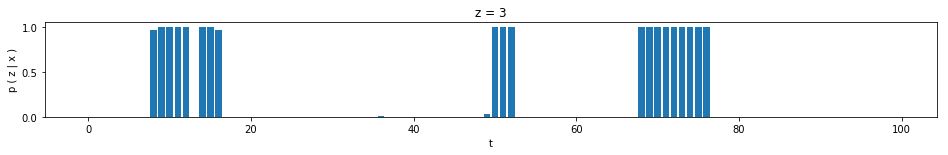

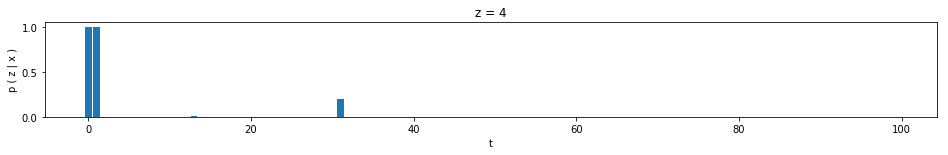

In [22]:
γ_test = plot_posteriors(test_data, π, μ, Σ, A)

### 2.10) Most likely state sequence of test data according to obtained marginal probabilities

In [23]:
def plot_most_likely_states(states, plot_title, time_steps = 100):
    
    x = np.arange(time_steps)
    
    plt.title(plot_title)
    plt.xlabel('t')
    plt.ylabel('most likely state')
    plt.yticks(np.arange(4) + 1)
    plt.scatter(x, states[:time_steps] + 1)
    plt.show()

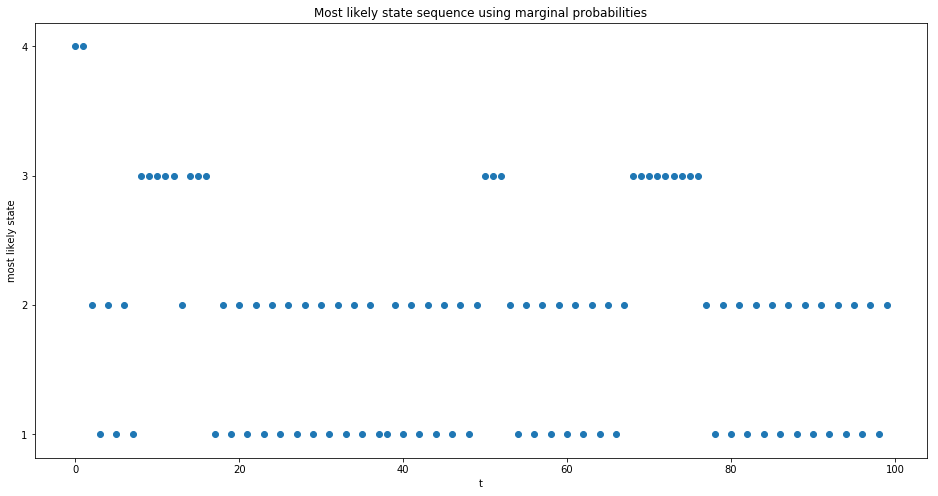

In [24]:
plot_most_likely_states(np.argmax(γ_test, axis=1), 'Most likely state sequence using marginal probabilities')

### 2.11) Most likely state sequence of test data using Viterbi algorithm

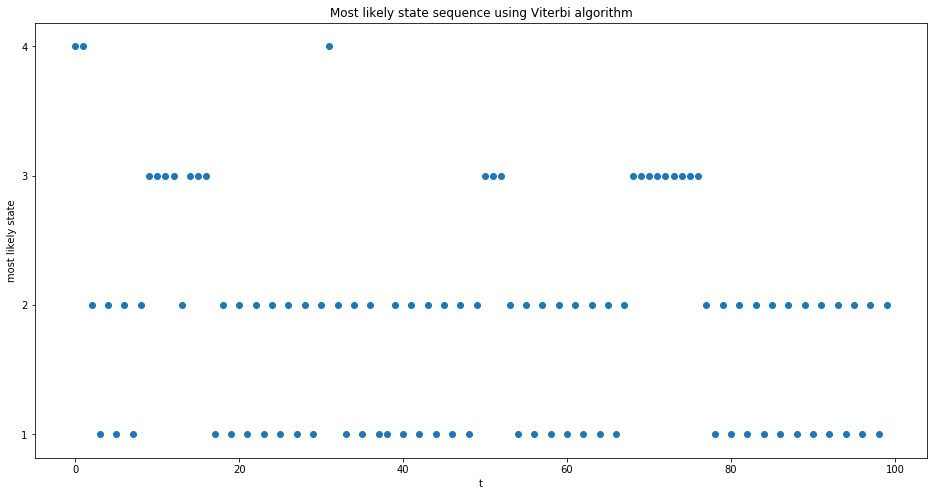

In [25]:
ω_test = viterbi(test_data, π, μ, Σ, A)
plot_most_likely_states(ω_test, 'Most likely state sequence using Viterbi algorithm')